In [23]:
import tensorflow as tf
import numpy as np

In [24]:
corpus_raw = "He is the king . The king is royal . She is the royal queen"

In [25]:
raw_sentence = corpus_raw.split(".")
sentences = []
for sentence in raw_sentence:
    sentences.append(sentence.strip().split())
sentences # 하나의 문장을 토큰의 리스트로 만들었다.

[['He', 'is', 'the', 'king'],
 ['The', 'king', 'is', 'royal'],
 ['She', 'is', 'the', 'royal', 'queen']]

In [26]:
data = [] # data[n][0] => 중심단어, data[n][1] => 주변단어.
WINDOW_SIZE = 2 # 윈도우 사이즈 설정
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        start_index = max(word_index - WINDOW_SIZE, 0) # 시작 인덱스 설정
        end_index = min(word_index + WINDOW_SIZE + 1, len(sentence)) # 끝인덱스 설정
        # (len(sentence)는 전체길이 즉 마지막 인덱스 보다 1 크다.)
        # word_index + WINDOW_SIZE + 1 이 len(sentence) 보다 클때 len(sentence) 를 반환시켜 인덱스 초과하는 오류 방지한다.
        # word_index + WINDOW_SIZE에 1을 더하는건 인덱스 슬라이스를 사용하기 위해.

        for nb_word in sentence[start_index:word_index]:
            data.append([word, nb_word])

        for nb_word in sentence[word_index+1:end_index]:
            data.append([word, nb_word])
data

[['He', 'is'],
 ['He', 'the'],
 ['is', 'He'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'He'],
 ['the', 'is'],
 ['the', 'king'],
 ['king', 'is'],
 ['king', 'the'],
 ['The', 'king'],
 ['The', 'is'],
 ['king', 'The'],
 ['king', 'is'],
 ['king', 'royal'],
 ['is', 'The'],
 ['is', 'king'],
 ['is', 'royal'],
 ['royal', 'king'],
 ['royal', 'is'],
 ['She', 'is'],
 ['She', 'the'],
 ['is', 'She'],
 ['is', 'the'],
 ['is', 'royal'],
 ['the', 'She'],
 ['the', 'is'],
 ['the', 'royal'],
 ['the', 'queen'],
 ['royal', 'is'],
 ['royal', 'the'],
 ['royal', 'queen'],
 ['queen', 'the'],
 ['queen', 'royal']]

In [40]:
words = []
for word in corpus_raw.split():
    if word != ".":
        words.append(word)
words = set(words) # 유니크한 단어 추출.

# 사전 선언.
word2int = {}
int2word = {}
vocab_size = len(words)

for i, word in enumerate(words): # 사전 채움
    word2int[word] = i
    int2word[i] = word

print(word2int)
print(int2word)


{'is': 0, 'The': 1, 'queen': 2, 'king': 3, 'royal': 4, 'She': 5, 'He': 6, 'the': 7}
{0: 'is', 1: 'The', 2: 'queen', 3: 'king', 4: 'royal', 5: 'She', 6: 'He', 7: 'the'}


In [28]:
def to_one_hot(word_index, vocab_size): # 원 핫 인코딩 함수.
    temp = np.zeros(vocab_size)
    temp[word_index] = 1
    return temp

In [29]:
x_train = []
y_train = []
for word in data:
    x_train.append(to_one_hot(word2int[word[0]], vocab_size)) # 중심단어 원핫 인코딩
    y_train.append(to_one_hot(word2int[word[1]], vocab_size)) # 주변단어 원핫 인코딩

In [30]:
x_train = np.asarray(x_train, dtype=np.float32) # 밖에는 그냥 리스트였어서 np.array로 바꿔줌
y_train = np.asarray(y_train, dtype=np.float32) # 밖에는 그냥 리스트였어서 np.array로 바꿔줌

In [31]:
class Word2Vec:
    def __init__(self, vocab_size=10, embedding_dim=5, optimizer='sgd', epochs=1000, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        if optimizer == 'adam':
            self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        else:
            self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
        self.epochs = epochs

        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim]))

        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))

    def vectorized(self, word_index):
        return (self.W1 + self.b1)[word_index]


    def train(self, x_train, y_train):
        for i in range(self.epochs):
            with tf.GradientTape() as tape:
                hidden_layer = tf.add(tf.matmul(x_train, self.W1), self.b1)
                output_layer = tf.add(tf.matmul(hidden_layer, self.W2), self.b2)

                pred = tf.nn.softmax(output_layer)
                loss = tf.reduce_mean(-tf.math.reduce_sum(y_train*tf.math.log(pred), axis=[1]))

                grads = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2])
                self.optimizer.apply_gradients(zip(grads, [self.W1, self.b1, self.W2, self.b2]))

            if i % 1000 == 0:
                print(loss)




In [32]:
w2v = Word2Vec(vocab_size=vocab_size, embedding_dim=5, optimizer='SGD', epochs=10000, learning_rate=0.1)
w2v.train(x_train, y_train)

tf.Tensor(4.6918526, shape=(), dtype=float32)
tf.Tensor(1.413231, shape=(), dtype=float32)
tf.Tensor(1.386983, shape=(), dtype=float32)
tf.Tensor(1.3795978, shape=(), dtype=float32)
tf.Tensor(1.3772302, shape=(), dtype=float32)
tf.Tensor(1.376185, shape=(), dtype=float32)
tf.Tensor(1.3756231, shape=(), dtype=float32)
tf.Tensor(1.3752809, shape=(), dtype=float32)
tf.Tensor(1.3750535, shape=(), dtype=float32)
tf.Tensor(1.3748931, shape=(), dtype=float32)


In [33]:
word2int

{'is': 0,
 'The': 1,
 'queen': 2,
 'king': 3,
 'royal': 4,
 'She': 5,
 'He': 6,
 'the': 7}

In [34]:
w2v.vectorized(word2int['queen']).numpy()

array([ 1.754069 , -1.9933643,  1.3126335,  1.4508238,  1.9035676],
      dtype=float32)

In [35]:
w2v.vectorized(word2int['king']).numpy()


array([1.7236911, 2.4175215, 1.7245193, 1.238209 , 0.5036832],
      dtype=float32)

In [36]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
vector = w2v.W1 + w2v.b1

model = TSNE(n_components=2, random_state=42)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vector)

normalizer = preprocessing.Normalizer()
vectors = normalizer.fit_transform(vectors, 'l2')


{'is', 'The', 'queen', 'king', 'royal', 'She', 'He', 'the'}
is [ 0.787192   -0.61670804]
The [-0.82485855  0.56533927]
queen [0.94978195 0.31291252]
king [-0.24413551  0.9697411 ]
royal [-0.15563494  0.98781466]
She [-0.2925513  -0.95624983]
He [-0.9756935  -0.21913934]
the [0.45033774 0.89285827]


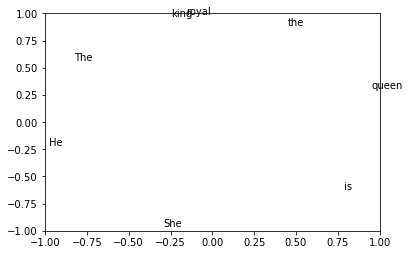

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim(left = -1, right=1)
ax.set_ylim(bottom = -1, top=1)
print(words)
for word in words:
    print(word, vectors[word2int[word]])
    ax.annotate(word, (vectors[word2int[word]][0], vectors[word2int[word]][1]))

plt.show()

In [2]:
import pandas as pd

df_news = pd.read_csv('./data/news.csv')


In [10]:
df_news['content'].iloc[0]

'2005년 10년만기 미국 국채수익률이  연방준비제도이사회(FRB)의 금리인상 지속에 따른 인플레이션 압력 완화로 연 5%를 넘어서기 어려울 것으로 전망됐다.    31일 씨티그룹 애널리스트들은 2005년에 미국의 인플레가 잘 제어될 것이라면서반면 내년 2년만기 국채수익률은 FRB의 지속적인 금리인상으로 연 4.00-4.50%  수준까지 상승하게 될 것이라고 예측했다.    씨티그룹은 단기 국채수익률이 상승세를 나타낼 것으로 보이는 반면 장기  국채수익률의 상승폭은 제한될 것으로 보여 수익률 곡선 평탄화가 가속화될 것이라고 덧붙였다.    씨티그룹은 내년 고용창출 호조가 가구당 수입증가를 견인할 것이라면서 고용시장 호전이 소비자지출을 떠받치게 될 것이라고 말했다'

In [13]:
sentences = df_news['content'].apply(lambda x:x.split('.    ')).tolist()

In [28]:
from konlpy.tag import Mecab
mecab = Mecab()

In [32]:
sentences = [mecab.morphs(token) for sentence in sentences for token in sentence]

In [33]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

In [34]:
word_embedding = model.wv['금리']

In [36]:
word_embedding

array([ 2.055307  , -7.350996  ,  6.7004814 ,  0.54158914, -2.7727094 ,
        1.001845  , -1.5213941 , -4.0525303 ,  1.5112025 , -0.7524304 ,
        0.449225  , -9.812559  , -1.5217018 , -0.02024336,  0.04897524,
        4.967686  , -2.1489346 , -1.1142644 , -1.9996036 ,  5.2611265 ,
       -2.7381408 ,  3.4204836 ,  3.971838  , -4.9012313 , -1.5263687 ,
        2.8062959 , -1.3538758 ,  6.173607  ,  8.253064  ,  0.8346908 ,
       -1.760262  , -6.4252477 ,  2.468377  ,  0.7615645 , -1.435305  ,
       -2.014398  , -4.6957874 , -4.003558  ,  1.2729903 ,  4.063239  ,
       -6.481788  , -5.9978886 ,  7.9655533 , -4.7727313 , -2.3683064 ,
        4.760497  , -4.5268755 , -6.117017  ,  1.4039214 , -4.4734535 ,
        0.53600997,  0.0902497 ,  1.3900996 ,  1.6737157 , -1.2223575 ,
        6.3844075 ,  3.0986817 , -2.3998418 ,  2.9756796 , -2.9151695 ,
       -1.3185133 , -1.8844396 ,  0.89639765,  0.73338926,  4.7100515 ,
        5.575199  ,  2.1257048 ,  5.2321615 ,  5.8952484 ,  0.50